In [1]:
#!/usr/bin/env python3
# coding: utf-8
""" Usage:
    python3 thai-student-stat.py directory
"""

' Usage:\n    python3 thai-student-stat.py directory\n'

In [2]:
import glob
import tgt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import edit_distance

VOWELS=['i', 'y', 'u', 'ɨ', 'ɤ', 'e', 'ɛ', 'ə', 'o',  'ɔ',  'a', 'ɚ']
CONSONS= ['p', 'pʰ', 't', 'tʰ', 'k', 'kʰ', 'ts', 'tsʰ', 'tʂ', 'tʂʰ', 'tɕ', 'tɕʰ', 'f', 'ɕ', 'x', 's', 
          'ʂ', 'ʐ', 'm', 'n', 'ŋ', 'l', 'ɥ', 'j', 'w']
LABELS = VOWELS+CONSONS
#print(CONSONS)

In [3]:
def contains_chinese(check_str):
    """
    判断字符串中是否包含中文
    :param check_str: {str} 需要检测的字符串
    :return: {bool} 包含返回True， 不包含返回False
    """
    for ch in check_str:
        if u'\u4e00' <= ch <= u'\u9fff':
            return True
    return False

def all_chinese(check_str):
    for ch in check_str:
        if not (u'\u4e00' <= ch <= u'\u9fff'):
            return False
    return True

In [4]:
def list_gen_and_plot(tplist, splist, TEMPL):
    vtplist = []
    vsplist = []
    for i in range(len(tplist)):
        if tplist[i] in TEMPL:
            vtplist.append(tplist[i])
            vsplist.append(splist[i])
    mat = confusion_matrix(vtplist, vsplist, labels=TEMPL)
    df_cm = pd.DataFrame(mat, index = TEMPL, columns = TEMPL)
    plt.figure(figsize = (20,15))
    sn.heatmap(df_cm, annot=True,cmap="OrRd",fmt="d")
    plt.xlabel("Thai children")
    plt.ylabel("Taiwan Instructor")
    plt.show()


In [5]:
def fdistance(S1,S2):
    a = len(S1)
    b = len(S2)
    fdn = {} # Global dict

    for x in range(a+1):
        for y in range(b+1):
            fdn[x,y] = 0
    
    for x in range(a+1):
        fdn[x,0] = x
    for y in range(b+1):
        fdn[0,y] = y

    print(fdn)
    for x in range(1,a+1):
        for y in range(1,b+1):
            if S1[x-1] == S2[y-1]: 
                c = 0 
            else:
                c = 1
            minc = min(fdn[x,y-1]+1, fdn[x-1,y]+1, fdn[x-1,y-1]+c)

    return fdn[x,y]

In [6]:
def substCost(x,y):
    if x == y: 
        return 0
    else: 
        return 1

def levenshtein(target, source):
    i = len(target)
    j = len(source)
    if i == 0:  
        return j
    elif j == 0: 
        return i

    return(min(levenshtein(target[:i-1],source)+1,
               levenshtein(target, source[:j-1])+1,
               levenshtein(target[:i-1], source[:j-1])+substCost(source[j-1],target[i-1])))

In [7]:
def opprint(t, s, op):
    for tag, i1, i2, j1, j2 in op:
        print('{:7}   a[{}:{}] --> b[{}:{}] {!r:>8} --> {!r}'.format(tag, i1, i2, j1, j2, t[i1:i2], s[j1:j2]))

In [8]:
def to_oplist(oplist):
    pop=[]
    for op in oplist:
        pop.append(op[0])
        
    return pop

In [9]:
import edit_distance

def stat_main(txtgridr):
    #print(txtgridr)
    txtlist = glob.glob(txtgridr+"/*.14")
    print("File list", txtlist)
    tplist = []
    splist = []
    tcvlist=[]
    scvlist=[]
    t6list=[]
    s6list=[]
    ttplist=[]
    tsplist=[]
 
    for txtgridf in txtlist:
        tg = tgt.io.read_textgrid(txtgridf, encoding='utf-8', include_empty_intervals=True)
        t1=tg.get_tier_by_name('IU/teacher')
        t4=tg.get_tier_by_name('IU/phone')
        t5=tg.get_tier_by_name('IU/syllable')
        t6=tg.get_tier_by_name('IU/tone')
        t7=tg.get_tier_by_name('IU/student-7')
        t10=tg.get_tier_by_name('IU/student-10')
        t11=tg.get_tier_by_name('EU/syllable')
        t12=tg.get_tier_by_name('EU/tone')
        
        for i in t1:
            t = i.text.replace(' ','').replace('*','').replace('^','')
            if all_chinese(t):
                for j in t7:
                    jtext = j.text.replace(' ','').replace('*','').replace('^','')

                    if i.text == jtext:
                        tap = t4.get_annotations_between_timepoints(i.start_time, i.end_time, left_overlap=True, right_overlap=True)
                        sap = t10.get_annotations_between_timepoints(j.start_time, j.end_time, left_overlap=True, right_overlap=True)
                        tacv = t5.get_annotations_between_timepoints(i.start_time, i.end_time, left_overlap=True, right_overlap=True)
                        sacv = t11.get_annotations_between_timepoints(j.start_time, j.end_time, left_overlap=True, right_overlap=True)
                        ta6 = t6.get_annotations_between_timepoints(i.start_time, i.end_time, left_overlap=True, right_overlap=True)
                        sa6 = t12.get_annotations_between_timepoints(j.start_time, j.end_time, left_overlap=True, right_overlap=True)

                        #print(tap, sap)
                        ntl=[]
                        stl=[]

                        if (len(tap) != len(sap)):
                            print(jtext, end=" ")
                            for iap in tap:
                                print(iap.text, end=" ")
                                if iap.text != "":
                                    ntl.append(iap.text)
                            print('->', end="")
                            for iap in sap:
                                print(iap.text, end=" ")
                                if iap.text != "":
                                    stl.append(iap.text)
                            #print()
                            sm = edit_distance.SequenceMatcher(a=ntl, b=stl)
                            op=sm.get_opcodes()
                            dist=sm.distance()
                            oplist = to_oplist(op)
                            print(oplist, dist)
                            #distce.SequenceMatcher(a=ntl, b=stl)
                            #c = fdistance(ntl,stl)
                            #c = levenshtein(stl, ntl)
                            #print(ntl, stl)
                            #op = dist.get_opcodes()
                            #mop = dist.matches()
                            #opprint(ntl,stl, op)
                            #print(ntl, stl, mop)
                            #print(ntl, stl, c)
                        else:
                            print(jtext, end=" ")
                            ptstr=""
                            psstr=""
                            tplist=[]
                            splist=[]
                            for tt, ss in zip(tap, sap):
                                try:
                                    #print('[',t.text,'][', s.text, ']')
                                    tstr = tt.text.replace(' ','')
                                    sstr = ss.text.replace(' ','')
                                    ptstr = ptstr + tstr + ' '
                                    psstr = psstr + sstr + ' '
                                    tplist.append(tstr)
                                    splist.append(sstr)
                                    ttplist.append(tstr)
                                    tsplist.append(sstr)
                                except:
                                    print('Exception')
                            
                            print(tplist, splist, end=" ")
                            sm = edit_distance.SequenceMatcher(a=tplist, b=splist)
                            op=sm.get_opcodes()
                            dist=sm.distance()
                            oplist = to_oplist(op)
                            print(oplist, dist)
                            #print(ptstr, psstr)
                                
    #print(len(tplist), len(splist))
    list_gen_and_plot(ttplist, tsplist, VOWELS)
    list_gen_and_plot(ttplist, tsplist, CONSONS)
    #print(tcvlist, scvlist)
    #list_gen_and_plot(tcvlist, scvlist, ["C","V","G","N"])

File list ['data\\ZOOM0001_LR.TextGrid.14', 'data\\ZOOM0002_LR.TextGrid.14', 'data\\ZOOM0003_LR.TextGrid.14', 'data\\ZOOM0004_LR.TextGrid.14', 'data\\ZOOM0004_做實驗.TextGrid.14', 'data\\ZOOM0005_LR-1.TextGrid.14', 'data\\ZOOM0005_LR.TextGrid.14', 'data\\ZOOM0007_Jinghuang.TextGrid.14', 'data\\ZOOM0007_LR_TextGrid.14', 'data\\ZOOM0008_test_one_by_one.TextGrid.14', 'data\\ZOOM0009_LR.TextGrid.14']
好 ['x', 'a', 'w'] ['x', 'a', 'w'] ['equal', 'equal', 'equal'] 0
好 ['x', 'a', 'w'] ['x', 'a', 'w'] ['equal', 'equal', 'equal'] 0
好 ['x', 'a', 'w'] ['x', 'a', 'w'] ['equal', 'equal', 'equal'] 0
好 ['x', 'a', 'w'] ['x', 'a', 'w'] ['equal', 'equal', 'equal'] 0
一 ['i'] ['i'] ['equal'] 0
一 ['i'] ['i'] ['equal'] 0
一 ['i'] ['i'] ['equal'] 0
一 ['i'] ['i'] ['equal'] 0
三 ['s', 'a', 'n'] ['s', 'a', 'n'] ['equal', 'equal', 'equal'] 0
四 ['s', 'ɨ'] ['s', 'ɨ'] ['equal', 'equal'] 0
四 ['s', 'ɨ'] ['s', 'ɤ'] ['equal', 'replace'] 1
五 ['u'] ['u'] ['equal'] 0
五 ['u'] ['u'] ['equal'] 0
六 ['l', 'j', 'o', 'w'] ['l', 'j', '

好燙 ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['x', 'a', 'u', 'tʰ', 'a', 'n'] ['equal', 'equal', 'replace', 'equal', 'equal', 'replace'] 2
好燙 ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
好燙 ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
好燙 ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['x', 'a', 'w', 'tʰ', 'a', 'n'] ['equal', 'equal', 'equal', 'equal', 'equal', 'replace'] 1
好燙 ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['x', 'a', 'u', 'tʰ', 'a', 'n'] ['equal', 'equal', 'replace', 'equal', 'equal', 'replace'] 2
好燙 ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
好燙 ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
好燙 ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['x', 'a', 'u', 'tʰ', 'a', 'n'] ['equal', 'equal', 'replace', 'equal', 'equal', 'replac

粽子 ['ts', 'o', 'ŋ', 'ts', 'ɨ'] ['ts', 'o', 'ŋ', 'ts', 'a'] ['equal', 'equal', 'equal', 'equal', 'replace'] 1
粽子 ['ts', 'o', 'ŋ', 'ts', 'ɨ'] ['ts', 'o', 'ŋ', 'ts', 'ɨ'] ['equal', 'equal', 'equal', 'equal', 'equal'] 0
粽子 ['ts', 'o', 'ŋ', 'ts', 'ɨ'] ['t', 'o', 'ŋ', 'ts', 'ɨ'] ['replace', 'equal', 'equal', 'equal', 'equal'] 1
粽子 ['ts', 'o', 'ŋ', 'ts', 'ɨ'] ['ts', 'o', 'ŋ', 'ts', 'ɨ'] ['equal', 'equal', 'equal', 'equal', 'equal'] 0
粽子 ['ts', 'o', 'ŋ', 'ts', 'ɨ'] ['ts', 'o', 'ŋ', 'ts', 'ɨ'] ['equal', 'equal', 'equal', 'equal', 'equal'] 0
粽子 ['ts', 'o', 'ŋ', 'ts', 'ɨ'] ['ts', 'o', 'ŋ', 'ts', 'ɨ'] ['equal', 'equal', 'equal', 'equal', 'equal'] 0
粽子 ['ts', 'o', 'ŋ', 'ts', 'ɨ'] ['ts', 'o', 'ŋ', 'ts', 'a'] ['equal', 'equal', 'equal', 'equal', 'replace'] 1
粽子 ['ts', 'o', 'ŋ', 'ts', 'ɨ'] ['ts', 'o', 'ŋ', 'ts', 'ɨ'] ['equal', 'equal', 'equal', 'equal', 'equal'] 0
粽子 ['ts', 'o', 'ŋ', 'ts', 'ɨ'] ['t', 'o', 'ŋ', 'ts', 'ɨ'] ['replace', 'equal', 'equal', 'equal', 'equal'] 1
粽子 ['ts', 'o', 'ŋ', 'ts', 'ɨ'] 

糖果 ['tʰ', 'a', 'ŋ', 'k', 'w', 'ɔ'] ['t', 'a', 'ŋ', 'k', 'w', 'ɔ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
糖果 ['tʰ', 'a', 'ŋ', 'k', 'w', 'ɔ'] ['tʰ', 'a', 'ŋ', 'k', 'w', 'ɔ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
糖果 ['tʰ', 'a', 'ŋ', 'k', 'w', 'ɔ'] ['tʰ', 'a', 'ŋ', 'k', 'w', 'a'] ['equal', 'equal', 'equal', 'equal', 'equal', 'replace'] 1
糖果 ['tʰ', 'a', 'ŋ', 'k', 'w', 'ɔ'] ['tʰ', 'a', 'n', 'k', 'w', 'ɔ'] ['equal', 'equal', 'replace', 'equal', 'equal', 'equal'] 1
糖果 ['tʰ', 'a', 'ŋ', 'k', 'w', 'ɔ'] ['tʰ', 'a', 'n', 'k', 'w', 'ɔ'] ['equal', 'equal', 'replace', 'equal', 'equal', 'equal'] 1
糖果 ['tʰ', 'a', 'ŋ', 'k', 'w', 'ɔ'] ['tʰ', 'a', 'n', 'k', 'u', 'a'] ['equal', 'equal', 'replace', 'equal', 'replace', 'replace'] 3
糖果 ['tʰ', 'a', 'ŋ', 'k', 'w', 'ɔ'] ['tʰ', 'a', 'n', 'k', 'w', 'a'] ['equal', 'equal', 'replace', 'equal', 'equal', 'replace'] 2
糖果 ['tʰ', 'a', 'ŋ', 'k', 'w', 'ɔ'] ['tʰ', 'a', 'n', 'k', 'w', 'a'] ['equal', 'equal', 'replace', 'equal', 'equal', 

紅色 ['x', 'o', 'ŋ', 's', 'ɤ'] ['x', 'o', 'ŋ', 's', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal'] 0
紅色 ['x', 'o', 'ŋ', 's', 'ɤ'] ['x', 'o', 'ŋ', 's', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal'] 0
紅色 ['x', 'o', 'ŋ', 's', 'ɤ'] ['x', 'o', 'ŋ', 's', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal'] 0
紅色 ['x', 'o', 'ŋ', 's', 'ɤ'] ['x', 'o', 'ŋ', 's', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal'] 0
紅色 ['x', 'o', 'ŋ', 's', 'ɤ'] ['x', 'o', 'ŋ', 's', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal'] 0
紅色 ['x', 'o', 'ŋ', 's', 'ɤ'] ['x', 'o', 'ŋ', 's', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal'] 0
紅色 ['x', 'o', 'ŋ', 's', 'ɤ'] ['x', 'o', 'ŋ', 's', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal'] 0
紅色 ['x', 'o', 'ŋ', 's', 'ɤ'] ['x', 'o', 'ŋ', 's', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal'] 0
紅色 ['x', 'o', 'ŋ', 's', 'ɤ'] ['x', 'o', 'ŋ', 's', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal'] 0
紅色 ['x', 'o', 'ŋ', 's', 'ɤ'] ['x', 'o', 'ŋ', 's', 'ɤ'] ['equal', 'equal',

跳 ['tʰ', 'j', 'a', 'w'] ['t', 'j', 'a', 'w'] ['replace', 'equal', 'equal', 'equal'] 1
跳 ['tʰ', 'j', 'a', 'w'] ['tʰ', 'j', 'a', 'w'] ['equal', 'equal', 'equal', 'equal'] 0
跳 ['tʰ', 'j', 'a', 'w'] ['tʰ', 'j', 'a', 'w'] ['equal', 'equal', 'equal', 'equal'] 0
跳 ['tʰ', 'j', 'a', 'w'] ['t', 'j', 'a', 'w'] ['replace', 'equal', 'equal', 'equal'] 1
跳 ['tʰ', 'j', 'a', 'w'] ['tʰ', 'j', 'a', 'w'] ['equal', 'equal', 'equal', 'equal'] 0
跳 ['tʰ', 'j', 'a', 'w'] ['tʰ', 'j', 'a', 'w'] ['equal', 'equal', 'equal', 'equal'] 0
跳 ['tʰ', 'j', 'a', 'w'] ['t', 'j', 'a', 'w'] ['replace', 'equal', 'equal', 'equal'] 1
跳 ['tʰ', 'j', 'a', 'w'] ['tʰ', 'j', 'a', 'w'] ['equal', 'equal', 'equal', 'equal'] 0
跳 ['tʰ', 'j', 'a', 'w'] ['tʰ', 'j', 'a', 'w'] ['equal', 'equal', 'equal', 'equal'] 0
預備 ['y', 'p', 'e', 'j'] ['y', 'p', 'e', 'j'] ['equal', 'equal', 'equal', 'equal'] 0
跳 ['tʰ', 'j', 'a', 'w'] ['t', 'j', 'a', 'w'] ['replace', 'equal', 'equal', 'equal'] 1
跳 ['tʰ', 'j', 'a', 'w'] ['tʰ', 'j', 'a', 'w'] ['equal', 'equal

早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tʂ', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tʂ', 'a', 'w', 'ts', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tʂ', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
早上 ts a w ʂ a ŋ ->tɕ j a ŋ tɕʰ j a ŋ ['insert', 'replace', 'equal', 'insert', 'replace', 'replace', 'equal', 'equal'] 5
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'w', 'ts', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'u', 'ts', 'a', 'ŋ'] ['replace', 'equal', 'replace', 'replace', 'equal'

中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['rep

中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午吃飯 ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
中午吃飯 ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['t', 'o', 'n', 'u', 'tʂʰ', 'u', 'f', 'a', 'n'] ['replace', 'equal', 'replace', 'equal', 'equal', 'replace', 'equal', 'equal', 'equal'] 3
中午吃飯 ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['t', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
中午吃飯 ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
中午吃飯 ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['tʂ', 'o', 'ŋ', 'u'

中午吃飯 ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['t', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
中午吃飯 ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['t', 'o', 'ŋ', 'u', 'tʂʰ', 'u', 'f', 'a', 'n'] ['replace', 'equal', 'equal', 'equal', 'equal', 'replace', 'equal', 'equal', 'equal'] 2
中午吃飯 ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
中午吃飯 ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
中午吃飯 ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['t', 'o', 'n', 'u', 'tʂʰ', 'u', 'f', 'a', 'n'] ['replace', 'equal', 'replace', 'equal', 'equal', 'replace', 'equal', 'equal', 'equal'] 3
中午吃飯 ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['

下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'j', 'a', 'y'] ['replace', 'equal', 'equal', 'replace'] 2
下午 ɕ j a u ->tɕʰ a u ['delete', 'replace', 'equal', 'equal'] 2
下午 ɕ j a u ->ɕ a u ['equal', 'delete', 'equal', 'equal'] 1
下午 ['ɕ', 'j', 'a', 'u'] ['ɕ', 'i', 'a', 'u'] ['equal', 'replace', 'equal', 'equal'] 1
下午 ['ɕ', 'j', 'a', 'u'] ['ɕ', 'j', 'a', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'i', 'a', 'u'] ['replace', 'replace', 'equal', 'equal'] 2
下午有中文課 ['ɕ', 'j', 'a', 'u', 'j', 'o', 'w', 'tʂ', 'o', 'ŋ', 'w', 'ə', 'n', 'kʰ', 'ɤ'] ['ɕ', 'j', 'a', 'u', 'j', 'o', 'w', 'tʂ', 'o', 'ŋ', 'w', 'ə', 'n', 'kʰ', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
下午有中文課 ['ɕ', 'j', 'a', 'u', 'j', 'o', 'w', 'tʂ', 'o', 'ŋ', 'w', 'ə', 'n', 'kʰ', 'ɤ'] ['ɕ', 'j', 'a', 'u', 'j', 'o', 'w', 'tʂ', 'o', 'ŋ', 'w', 'ə', 'n', 'kʰ', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 

下午有中文課 ['ɕ', 'j', 'a', 'u', 'j', 'o', 'w', 'tʂ', 'o', 'ŋ', 'w', 'ə', 'n', 'kʰ', 'ɤ'] ['ɕ', 'j', 'a', 'u', 'j', 'o', 'w', 'tʂ', 'o', 'ŋ', 'w', 'ə', 'n', 'kʰ', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
下午有中文課 ɕ j a u j o w tʂ o ŋ w ə n kʰ ɤ ->tɕʰ a u j o w tʂ o ŋ w ə n kʰ ɤ ['delete', 'replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 2
下午有中文課 ɕ j a u j o w tʂ o ŋ w ə n kʰ ɤ ->tɕʰ a u j o w tʂ o ŋ w ə n kʰ ɤ ['delete', 'replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 2
下午有中文課 ['ɕ', 'j', 'a', 'u', 'j', 'o', 'w', 'tʂ', 'o', 'ŋ', 'w', 'ə', 'n', 'kʰ', 'ɤ'] ['ɕ', 'j', 'a', 'u', 'j', 'o', 'w', 'tʂ', 'o', 'ŋ', 'w', 'ə', 'n', 'kʰ', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal',

晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a', 'n'] ['equal', 'equal', 'equal', 'equal', 'equal', 'replace'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['b', 'ə', 'n', 'ʂ', 'a', 'ŋ'] ['replace', 'replace', 'equal', 'equal', 'equal', 'equal'] 2
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'tɕ', 'a', 'n'] ['equal', 'equal', 'equal', 'replace', 'equal', 'replace'] 2
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 't', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'ŋ', 'ts', 'a', 'ŋ'] ['equal', 'equal', 'replace', 'replace', 'equal', 'equal'] 2
晚上 w a n ʂ a ŋ ->w a n ɕ j a ŋ ['equal', 'equal', 'equal', 'insert', 'replace', 'equal', 'equal'] 2
晚上 ['w', 'a', 'n', 'ʂ', 'a',

晚上要睡覺 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'j', 'a', 'w', 'ʂ', 'w', 'e', 'j', 'tɕ', 'ɥ', 'ɛ'] ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'j', 'a', 'w', 'ts', 'w', 'e', 'j', 'tɕ', 'j', 'a'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'replace', 'equal', 'equal', 'equal', 'equal', 'replace', 'replace'] 3
晚上要睡覺 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'j', 'a', 'w', 'ʂ', 'w', 'e', 'j', 'tɕ', 'ɥ', 'ɛ'] ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'j', 'a', 'w', 'ʂ', 'w', 'e', 'j', 'tɕ', 'ɥ', 'ɛ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
晚上要睡覺 w a n ʂ a ŋ j a w ʂ w e j tɕ ɥ ɛ ->w a n ʂ a ŋ i a w ts w e j tɕ i a w ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'replace', 'equal', 'equal', 'replace', 'equal', 'equal', 'equal', 'equal', 'insert', 'replace', 'replace'] 5
晚上要睡覺 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'j', 'a', 'w', 'ʂ', 'w', 'e', 'j', 'tɕ', 'ɥ', 'ɛ'] ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'

中午吃飯 ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
中午吃飯 ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['t', 'o', 'n', 'u', 'tʂʰ', 'u', 'f', 'a', 'n'] ['replace', 'equal', 'replace', 'equal', 'equal', 'replace', 'equal', 'equal', 'equal'] 3
中午吃飯 ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['t', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
中午吃飯 ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
中午吃飯 ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
中午吃飯 ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['tʂ'

下午有中文課 ɕ j a u j o w tʂ o ŋ w ə n kʰ ɤ ->tɕʰ a u j o w tʂ o ŋ w ə n kʰ ɤ ['delete', 'replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 2
下午有中文課 ['ɕ', 'j', 'a', 'u', 'j', 'o', 'w', 'tʂ', 'o', 'ŋ', 'w', 'ə', 'n', 'kʰ', 'ɤ'] ['ɕ', 'j', 'a', 'u', 'j', 'o', 'w', 'tʂ', 'o', 'ŋ', 'w', 'ə', 'n', 'kʰ', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
下午有中文課 ['ɕ', 'j', 'a', 'u', 'j', 'o', 'w', 'tʂ', 'o', 'ŋ', 'w', 'ə', 'n', 'kʰ', 'ɤ'] ['ɕ', 'j', 'a', 'u', 'j', 'o', 'w', 'tʂ', 'o', 'ŋ', 'w', 'ə', 'n', 'kʰ', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
晚上要睡覺 w a n ʂ a ŋ j a w ʂ w e j tɕ ɥ ɛ ->b w ə n tsʰ a ŋ j a w ʂ w e j ts j a w ['insert', 'equal', 'replace', 'equal', 'replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal',

早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['t', 'a', 'w', 'ts', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tʂ', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tʂ', 'a', 'w', 'ts', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tʂ', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
早上 ts a w ʂ a ŋ ->tɕ j a ŋ tɕʰ j a ŋ ['insert', 'replace', 'equal', 'insert', 'replace', 'replace', 'equal', 'equal'] 5
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'w', 'ts', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'replace', 'equal', '

下午有中文課 ['ɕ', 'j', 'a', 'u', 'j', 'o', 'w', 'tʂ', 'o', 'ŋ', 'w', 'ə', 'n', 'kʰ', 'ɤ'] ['ɕ', 'j', 'a', 'u', 'j', 'o', 'w', 'tʂ', 'o', 'ŋ', 'w', 'ə', 'n', 'kʰ', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
下午有中文課 ['ɕ', 'j', 'a', 'u', 'j', 'o', 'w', 'tʂ', 'o', 'ŋ', 'w', 'ə', 'n', 'kʰ', 'ɤ'] ['ɕ', 'j', 'a', 'u', 'j', 'o', 'w', 'tʂ', 'o', 'ŋ', 'w', 'ə', 'n', 'kʰ', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
下午有中文課 ['ɕ', 'j', 'a', 'u', 'j', 'o', 'w', 'tʂ', 'o', 'ŋ', 'w', 'ə', 'n', 'kʰ', 'ɤ'] ['tɕʰ', 'j', 'a', 'u', 'j', 'o', 'w', 'tʂ', 'o', 'ŋ', 'w', 'ə', 'n', 'kʰ', 'ɤ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
下午有中文課 ['ɕ', 'j', 'a', 'u', 'j', 'o', 'w', 'tʂ', 'o', 'ŋ', 'w', 'ə', 'n', 'kʰ', 'ɤ'] ['ɕ', 'j

中午吃飯 ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['t', 'o', 'n', 'u', 'tʂʰ', 'u', 'f', 'a', 'n'] ['replace', 'equal', 'replace', 'equal', 'equal', 'replace', 'equal', 'equal', 'equal'] 3
中午吃飯 ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['t', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
中午吃飯 ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
中午吃飯 ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
中午吃飯 ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['tʂ', 'o', 'ŋ', 'u', 'tʂʰ', 'ɨ', 'f', 'a', 'n'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
中午吃飯 tʂ o ŋ u tʂʰ ɨ f a n ->tʂ o ŋ u tʂʰ ɨ x w a n ['equal'

早上 ts a w ʂ a ŋ ->tɕʰ j a w ts a n ['insert', 'replace', 'equal', 'equal', 'replace', 'equal', 'replace'] 4
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['t', 'a', 'w', 'ts', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tʂ', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
早上 ['ts', 'a',

下午 ɕ j a u ->ɕ a u ['equal', 'delete', 'equal', 'equal'] 1
下午 ['ɕ', 'j', 'a', 'u'] ['ɕ', 'i', 'a', 'u'] ['equal', 'replace', 'equal', 'equal'] 1
下午 ['ɕ', 'j', 'a', 'u'] ['ɕ', 'j', 'a', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'i', 'a', 'u'] ['replace', 'replace', 'equal', 'equal'] 2
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a', 'n'] ['equal', 'equal', 'equal', 'equal', 'equal', 'replace'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['b', 'ə', 'n', 'ʂ', 'a', 'ŋ'] ['replace', 'replace', 'equal', 'equal', 'equal', 'equal'] 2
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'tɕ', 'a', 'n'] ['equal', 'equal', 'equal', 'replace', 'equal', 'replace'] 2
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 't', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a'

早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['t', 'a', 'w', 't', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'w', 't', 'a', 'n'] ['replace', 'equal', 'equal', 'replace', 'equal', 'replace'] 3
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tʂ', 'a', 'w', 't', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'w', 'ʂ', 'a', 'n'] ['replace', 'equal', 'equal', 'equal', 'equal', 'replace'] 2
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tʂ', 'a', 'w', 'tʂʰ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
早上 ts a w ʂ a ŋ ->ts j a w ɕ j a ŋ ['equal', 'insert', 'equal', 'equal', 'insert', 'replace', 'equal', 'equal'] 3
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tsʰ', 'a', 'u', 'tsʰ', 'a', 'ŋ'] ['replace', 'equal', 'replace', 'replace', 'equ

中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 tʂ o ŋ u ->t o ŋ p u ['replace', 'equal', 'equal', 'insert', 'equal'] 2
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tɕ', 'o', 'ŋ', 'u'] ['replace', 

晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['u', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'ŋ', 'ʂ', 'a', 'ŋ'] ['equal', 'equal', 'replace', 'equal', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['u', 'a', 'n', 'ts', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
晚上 w a n ʂ a ŋ ->w a ʂ a ŋ ['equal', 'equal', 'delete', 'equal', 'equal', 'equal'] 1
晚上 w a n ʂ a ŋ ->w a ʂ a n ['equal', 'equal', 'delete', 'equal', 'equal', 'replace'] 2
晚上 w a n ʂ a ŋ ->w a ʂ a n ['equal', 'equal', 'delete', 'equal', 'equal', 'replace'] 2
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ts', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 't', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal

上學 ['ʂ', 'a', 'ŋ', 'ɕ', 'ɥ', 'ɛ'] ['ʂ', 'a', 'ŋ', 'ɕ', 'ɥ', 'ɛ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
上學 ['ʂ', 'a', 'ŋ', 'ɕ', 'ɥ', 'ɛ'] ['ts', 'a', 'ŋ', 'tɕʰ', 'ɥ', 'ɛ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
上學 ['ʂ', 'a', 'ŋ', 'ɕ', 'ɥ', 'ɛ'] ['ʂ', 'a', 'ŋ', 'ɕ', 'ɥ', 'ɛ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
上學 ['ʂ', 'a', 'ŋ', 'ɕ', 'ɥ', 'ɛ'] ['ʂ', 'a', 'ŋ', 'ɕ', 'ɥ', 'ɛ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
上學 ['ʂ', 'a', 'ŋ', 'ɕ', 'ɥ', 'ɛ'] ['ts', 'a', 'ŋ', 'tɕʰ', 'ɥ', 'ɛ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
上學 ['ʂ', 'a', 'ŋ', 'ɕ', 'ɥ', 'ɛ'] ['ʂ', 'a', 'ŋ', 'ɕ', 'ɥ', 'ɛ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
上學 ['ʂ', 'a', 'ŋ', 'ɕ', 'ɥ', 'ɛ'] ['ʂ', 'a', 'ŋ', 'ɕ', 'ɥ', 'ɛ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
上學 ['ʂ', 'a', 'ŋ', 'ɕ', 'ɥ', 'ɛ'] ['ts', 'a', 'ŋ', 'tɕʰ', 'ɥ', 'ɛ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
早上上

我 w ɔ ->ɔ ['delete', 'equal'] 1
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 w ɔ ->ɔ ['delete', 'equal'] 1
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'a'] ['equal', 'replace'] 1
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 w ɔ ->ɔ ['delete', 'equal'] 1
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 

我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a', 'n'] ['equal', 'equal', 'equal', 'equal', 'equal', 'replace'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['b', 'ə', 'n', 'ʂ', 'a', 'ŋ'] ['replace', 'replace', 'equal', 'equal', 'equal', 'equal'] 2
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'tɕ', 'a', 'n'] ['equal', 'equal', 'equal', 'replace', 'equal', 'replace'] 2
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', '

我 w ɔ ->ɔ ['delete', 'equal'] 1
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 w ɔ ->ɔ ['delete', 'equal'] 1
我 w ɔ ->ɔ ['delete', 'equal'] 1
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 w ɔ ->ɔ ['delete', 'equal'] 1
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'a'] ['equal', 'replace'] 1
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['

游泳 ['j', 'o', 'w', 'j', 'o', 'ŋ'] ['j', 'o', 'w', 'j', 'o', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
游泳 ['j', 'o', 'w', 'j', 'o', 'ŋ'] ['i', 'o', 'w', 'j', 'o', 'ŋ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
游泳 j o w j o ŋ ->o w j o ŋ ['delete', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
我晚上游泳 ['w', 'ɔ', 'w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'j', 'o', 'w', 'j', 'o', 'ŋ'] ['w', 'ɔ', 'w', 'a', 'n', 'tsʰ', 'a', 'ŋ', 'j', 'o', 'w', 'j', 'o', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
我晚上游泳 w ɔ w a n ʂ a ŋ j o w j o ŋ ->w ɔ w a n ɕ j a ŋ j o w j o ŋ ['equal', 'equal', 'equal', 'equal', 'equal', 'insert', 'replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 2
我晚上游泳 ['w', 'ɔ', 'w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'j', 'o', 'w', 'j', 'o', 'ŋ'] ['w', 'ɔ', 'w', 'a', 'n', 'ʂ', 'a', 'n', 'j', 'o', 'w', 'j', 'o', 'ŋ'] ['equal', 'equal', 'equal', 'equa

我 w ɔ ->ɔ ['delete', 'equal'] 1
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 w ɔ ->ɔ ['delete', 'equal'] 1
我 w ɔ ->ɔ ['delete', 'equal'] 1
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 w ɔ ->ɔ ['delete', 'equal'] 1
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'a'] ['equal', 'replace'] 1
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['

我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 w ɔ ->ɔ ['delete', 'equal'] 1
我 w ɔ ->ɔ ['delete', 'equal'] 1
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 w ɔ ->ɔ ['delete', 'equal'] 1
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'a'] ['equal', 'replace'] 1
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
吃 

我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 w ɔ ->ɔ ['delete', 'equal'] 1
我 w ɔ ->ɔ ['delete', 'equal'] 1
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 w ɔ ->ɔ ['delete', 'equal'] 1
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'a'] ['equal', 'replace'] 1
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 

我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 w ɔ ->ɔ ['delete', 'equal'] 1
我 w ɔ ->ɔ ['delete', 'equal'] 1
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 w ɔ ->ɔ ['delete', 'equal'] 1
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'a'] ['equal', 'replace'] 1
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我晚

我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 w ɔ ->ɔ ['delete', 'equal'] 1
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 w ɔ ->ɔ ['delete', 'equal'] 1
我 w ɔ ->ɔ ['delete', 'equal'] 1
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 w ɔ ->ɔ ['delete', 'equal'] 1
我 ['w', 'ɔ'] ['w', 'ɔ'] ['equal', 'equal'] 0
我 ['w', 'ɔ'] ['w'

早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'w', 't', 'a', 'n'] ['replace', 'equal', 'equal', 'replace', 'equal', 'replace'] 3
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tʂ', 'a', 'w', 't', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'w', 'ʂ', 'a', 'n'] ['replace', 'equal', 'equal', 'equal', 'equal', 'replace'] 2
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tʂ', 'a', 'w', 'tʂʰ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
早上 ts a w ʂ a ŋ ->ts j a w ɕ j a ŋ ['equal', 'insert', 'equal', 'equal', 'insert', 'replace', 'equal', 'equal'] 3
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tsʰ', 'a', 'u', 'tsʰ', 'a', 'ŋ'] ['replace', 'equal', 'replace', 'replace', 'equal', 'equal'] 3
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'u', 'ɕ', 'a', 'n'] ['replace', 'equal', 'replace', 'replace', '

早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tsʰ', 'a', 'u', 'tsʰ', 'a', 'ŋ'] ['replace', 'equal', 'replace', 'replace', 'equal', 'equal'] 3
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'u', 'ɕ', 'a', 'n'] ['replace', 'equal', 'replace', 'replace', 'equal', 'replace'] 4
中 ['tʂ', 'o', 'ŋ'] ['ts', 'o', 'ŋ'] ['replace', 'equal', 'equal'] 1
中 ['tʂ', 'o', 'ŋ'] ['ts', 'o', 'ŋ'] ['replace', 'equal', 'equal'] 1
中 ['tʂ', 'o', 'ŋ'] ['tʂ', 'o', 'ŋ'] ['equal', 'equal', 'equal'] 0
中 ['tʂ', 'o', 'ŋ'] ['t', 'o', 'ŋ'] ['replace', 'equal', 'equal'] 1
中 ['tʂ', 'o', 'ŋ'] ['tʂ', 'o', 'ŋ'] ['equal', 'equal', 'equal'] 0
中 ['tʂ', 'o', 'ŋ'] ['tʂ', 'o', 'ŋ'] ['equal', 'equal', 'equal'] 0
中 ['tʂ', 'o', 'ŋ'] ['tʂ', 'o', 'ŋ'] ['equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 

下午 ['ɕ', 'j', 'a', 'u'] ['ɕ', 'i', 'a', 'u'] ['equal', 'replace', 'equal', 'equal'] 1
下午 ['ɕ', 'j', 'a', 'u'] ['ɕ', 'j', 'a', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'i', 'a', 'u'] ['replace', 'replace', 'equal', 'equal'] 2
下午 ɕ j a u ->tɕʰ a u ['delete', 'replace', 'equal', 'equal'] 2
下午 ['ɕ', 'j', 'a', 'u'] ['ɕ', 'j', 'a', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'j', 'a', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'j', 'a', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
下午 ɕ j a u ->tɕʰ a u ['delete', 'replace', 'equal', 'equal'] 2
下午 ['ɕ', 'j', 'a', 'u'] ['ɕ', 'j', 'a', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
下午 ['ɕ', 'j', 'a', 'u'] ['s', 'j', 'a', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
下午 ['ɕ', 'j', 'a', 'u'] ['ɕ', 'j', 'a', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
下午 ['ɕ', 'j', 'a', 'u'] ['ɕ', 'j', 'a', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
下午 ['ɕ', 'j', 'a

晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['u', 'a', 'n', 'ts', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
晚上 w a n ʂ a ŋ ->w a ʂ a ŋ ['equal', 'equal', 'delete', 'equal', 'equal', 'equal'] 1
晚上 w a n ʂ a ŋ ->w a ʂ a n ['equal', 'equal', 'delete', 'equal', 'equal', 'replace'] 2
晚上 w a n ʂ a ŋ ->w a ʂ a n ['equal', 'equal', 'delete', 'equal', 'equal', 'replace'] 2
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ts', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 't', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 's', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ts', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'ŋ', 'tɕʰ', 'a', 'w'] ['equal', 'equal', 'replace', 'replace', 'equal',

中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 tʂ o ŋ u ->t o ŋ p u ['replace', 'equal', 'eq

晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 's', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ts', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'ŋ', 'tɕʰ', 'a', 'w'] ['equal', 'equal', 'replace', 'replace', 'equal', 'replace'] 3
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ɕ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ts', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['u', 'a', 'n', 'ts', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
下午 ɕ j a u ->tɕʰ a u ['delete', 'replace', 'equal', 'equal'] 2
下午 ['ɕ', 'j', 'a', 'u'] ['ɕ', 'j', 'a', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'j', 'a', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
下午 ['ɕ', '

早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tʂ', 'a', 'w', 't', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'w', 'ʂ', 'a', 'n'] ['replace', 'equal', 'equal', 'equal', 'equal', 'replace'] 2
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tʂ', 'a', 'w', 'tʂʰ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
早上 ts a w ʂ a ŋ ->ts j a w ɕ j a ŋ ['equal', 'insert', 'equal', 'equal', 'insert', 'replace', 'equal', 'equal'] 3
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tsʰ', 'a', 'u', 'tsʰ', 'a', 'ŋ'] ['replace', 'equal', 'replace', 'replace', 'equal', 'equal'] 3
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'u', 'ɕ', 'a', 'n'] ['replace', 'equal', 'replace', 'replace', 'equal', 'replace'] 4
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'equal', 'eq

早上好熱 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['ts', 'a', 'u', 'tsʰ', 'a', 'ŋ', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['equal', 'equal', 'replace', 'replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 2
早上好熱 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['tɕ', 'a', 'w', 'ʂ', 'a', 'n', 'x', 'a', 'u', 'ʐ', 'ɤ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 3
早上好熱 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['tɕ', 'a', 'w', 'tʂʰ', 'a', 'ŋ', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 2
中午好熱 ['tʂ', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['tʂ', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'l', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'replace', 'equal'] 1
中午好熱 ['tʂ', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['tʂ', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['equal', 'equal', 'equal', 'equal'

中午好涼快 tʂ o ŋ u x a w l j a ŋ kʰ w a j ->t o ŋ u a w l j a nŋ k w a j ['replace', 'equal', 'equal', 'equal', 'delete', 'equal', 'equal', 'equal', 'equal', 'equal', 'replace', 'replace', 'equal', 'equal', 'equal'] 4
中午好涼快 ['tʂ', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'l', 'j', 'a', 'ŋ', 'kʰ', 'w', 'a', 'j'] ['tʂ', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'l', 'j', 'a', 'n', 'k', 'w', 'a', 'j'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'replace', 'replace', 'equal', 'equal', 'equal'] 2
下午好涼快 ['ɕ', 'j', 'a', 'u', 'x', 'a', 'w', 'l', 'j', 'a', 'ŋ', 'kʰ', 'w', 'a', 'j'] ['ɕ', 'i', 'a', 'u', 'x', 'a', 'w', 'l', 'j', 'a', 'n', 'kʰ', 'w', 'a', 'j'] ['equal', 'replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'replace', 'equal', 'equal', 'equal', 'equal'] 2
下午好涼快 ['ɕ', 'j', 'a', 'u', 'x', 'a', 'w', 'l', 'j', 'a', 'ŋ', 'kʰ', 'w', 'a', 'j'] ['tɕʰ', 'i', 'a', 'u', 'x', 'a', 'w', 'l', 'j', 'a', 'ŋ', 'kʰ', 'w', 'a', 'j'] ['replace', 'replac

晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'tsʰ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'ã', 'n', 'ʂ', 'ã', 'ŋ'] ['equal', 'replace', 'equal', 'equal', 'replace', 'equal'] 2
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['u', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'ŋ', 'ʂ', 'a', 'ŋ'] ['equal', 'equal', 'replace', 'equal', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['u', 'a', 'n', 'ts', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
晚上 w a n ʂ a ŋ ->w a ʂ a ŋ ['equal', 'equal', 'delete', 'equal', 'equal', 'equal'] 1
晚上 w a n ʂ a ŋ ->w a ʂ a n ['equal', 'equa

下午好熱 ['ɕ', 'j', 'a', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['ɕ', 'i', 'a', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['equal', 'replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
下午好熱 ɕ j a u x a w ʐ ɤ ->t j a u l a w ɤ ['replace', 'equal', 'equal', 'equal', 'replace', 'equal', 'equal', 'delete', 'equal'] 3
下午好熱 ['ɕ', 'j', 'a', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['tɕʰ', 'j', 'a', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
下午好熱 ['ɕ', 'j', 'a', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['ɕ', 'j', 'a', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
下午好熱 ['ɕ', 'j', 'a', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['tɕʰ', 'j', 'a', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
下午好熱 ['ɕ', 'j', 'a', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['ɕ', 'i', 'a', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['equal', 'replace', 'equal', 'equal', 

晚上好冷 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'x', 'a', 'w', 'l', 'ə', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'x', 'a', 'w', 'l', 'ə', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
晚上好冷 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'x', 'a', 'w', 'l', 'ə', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'x', 'a', 'w', 'ɹ', 'ə', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上好冷 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'x', 'a', 'w', 'l', 'ə', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a', 'n', 'x', 'a', 'w', 'l', 'ə', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
好冷 ['x', 'a', 'w', 'l', 'ə', 'ŋ'] ['x', 'a', 'u', 'l', 'ə', 'ŋ'] ['equal', 'equal', 'replace', 'equal', 'equal', 'equal'] 1
好冷 ['x', 'a', 'w', 'l', 'ə', 'ŋ'] ['x', 'ã', 'u', 'n', 'ə', 'ŋ'] ['equal', 'replace', 'replace', 'replace', 'equal', 'equal'] 3
好冷 ['x', 'a', 'w', 'l', 'ə', 

晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['b', 'ə', 'n', 'ʂ', 'a', 'ŋ'] ['replace', 'replace', 'equal', 'equal', 'equal', 'equal'] 2
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'tɕ', 'a', 'n'] ['equal', 'equal', 'equal', 'replace', 'equal', 'replace'] 2
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 't', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'ŋ', 'ts', 'a', 'ŋ'] ['equal', 'equal', 'replace', 'replace', 'equal', 'equal'] 2
晚上 w a n ʂ a ŋ ->w a n ɕ j a ŋ ['equal', 'equal', 'equal', 'insert', 'replace', 'equal', 'equal'] 2
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
晚上 ['w', 'a', 'n', 'ʂ', 'a', '

中午好熱 ['tʂ', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['tʂ', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
中午好熱 ['tʂ', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['t', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
中午好熱 ['tʂ', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['tʂ', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
中午好熱 ['tʂ', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['tʂ', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'l', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'replace', 'equal'] 1
中午好熱 ['tʂ', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['tʂ', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'ʐ', 'ɚ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'replace'] 1
中午好熱 ['tʂ', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['tʂ', 'o', 'ŋ', 'u', 'x', '

早上好熱 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['tɕ', 'a', 'w', 'tsʰ', 'a', 'ŋ', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 2
早上好熱 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['ts', 'a', 'u', 'tsʰ', 'a', 'ŋ', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['equal', 'equal', 'replace', 'replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 2
早上好熱 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['tɕ', 'a', 'w', 'ʂ', 'a', 'n', 'x', 'a', 'u', 'ʐ', 'ɤ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 3
早上好熱 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['tɕ', 'a', 'w', 'tʂʰ', 'a', 'ŋ', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 2
早上好熱 ts a w ʂ a ŋ x a w ʐ ɤ ->ts ɔ ə tsʰ j a ŋ x a u ʐ ɤ ['equal', 'insert', 'replace', 'rep

中午好熱 ['tʂ', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['tʂ', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'ʐ', 'ɚ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'replace'] 1
中午好熱 ['tʂ', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['tʂ', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
中午好熱 ['tʂ', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['t', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
晚上好涼快 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'x', 'a', 'w', 'l', 'j', 'a', 'ŋ', 'kʰ', 'w', 'a', 'j'] ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'x', 'a', 'w', 'l', 'j', 'a', 'ŋ', 'kʰ', 'w', 'a', 'j'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
晚上好涼快 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ', 'x', 'a', 'w', 'l', 'j', 'a', 'ŋ', 'kʰ', 'w', 'a', 'j'] ['w', 'a', 'n', 's'

早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['t', 'a', 'w', 'ts', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tʂ', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tʂ', 'a', 'w', 'ts', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tʂ', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
早上 ts a w ʂ a ŋ ->tɕ j a ŋ tɕʰ j a ŋ ['insert', 'replace', 'equal', 'insert', 'replace', 'replace', 'equal', 'equal

下午好熱 ['ɕ', 'j', 'a', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['ɕ', 'i', 'a', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['equal', 'replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
下午好熱 ɕ j a u x a w ʐ ɤ ->t j a u l a w ɤ ['replace', 'equal', 'equal', 'equal', 'replace', 'equal', 'equal', 'delete', 'equal'] 3
下午好熱 ['ɕ', 'j', 'a', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['tɕʰ', 'j', 'a', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
下午好熱 ['ɕ', 'j', 'a', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['ɕ', 'j', 'a', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
下午好熱 ['ɕ', 'j', 'a', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['tɕʰ', 'j', 'a', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
好熱 ['x', 'a', 'w', 'ʐ', 'ɤ'] ['x', 'a', 'w', 'ʐ', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal'] 0
好熱 ['x', 'a', 'w', 'ʐ', 'ɤ'] ['x'

中午好熱 ['tʂ', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['t', 'o', 'ŋ', 'u', 'x', 'a', 'w', 'ʐ', 'ɤ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
好熱 ['x', 'a', 'w', 'ʐ', 'ɤ'] ['x', 'a', 'w', 'ʐ', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal'] 0
好熱 ['x', 'a', 'w', 'ʐ', 'ɤ'] ['x', 'a', 'w', 'ʐ', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal'] 0
好熱 ['x', 'a', 'w', 'ʐ', 'ɤ'] ['x', 'a', 'u', 'l', 'ɤ'] ['equal', 'equal', 'replace', 'replace', 'equal'] 2
好熱 ['x', 'a', 'w', 'ʐ', 'ɤ'] ['x', 'a', 'u', 'ʐ', 'ɤ'] ['equal', 'equal', 'replace', 'equal', 'equal'] 1
好熱 ['x', 'a', 'w', 'ʐ', 'ɤ'] ['x', 'a', 'w', 'ʐ', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal'] 0
好熱 ['x', 'a', 'w', 'ʐ', 'ɤ'] ['x', 'a', 'w', 'ʐ', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal'] 0
好熱 ['x', 'a', 'w', 'ʐ', 'ɤ'] ['x', 'a', 'w', 'ʐ', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal'] 0
好熱 ['x', 'a', 'w', 'ʐ', 'ɤ'] ['x', 'a', 'w', 'ʐ', 'ɤ'] ['equal', 'equal', 'equal', 'equal

早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['t', 'a', 'w', 't', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'w', 't', 'a', 'n'] ['replace', 'equal', 'equal', 'replace', 'equal', 'replace'] 3
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tʂ', 'a', 'w', 't', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'w', 'ʂ', 'a', 'n'] ['replace', 'equal', 'equal', 'equal', 'equal', 'replace'] 2
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tʂ', 'a', 'w', 'tʂʰ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
早上 ts a w ʂ a ŋ ->ts j a w ɕ j a ŋ ['equal', 'insert', 'equal', 'equal', 'insert', 'replace', 'equal', 'equal'] 3
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tsʰ', 'a', 'u', 'tsʰ', 'a', 'ŋ'] ['replace', 'equal', 'replace', 'replace', 'equ

下午 ['ɕ', 'j', 'a', 'u'] ['ɕ', 'j', 'a', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
下午 ['ɕ', 'j', 'a', 'u'] ['ɕ', 'j', 'a', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'i', 'a', 'u'] ['replace', 'replace', 'equal', 'equal'] 2
下午 ['ɕ', 'j', 'a', 'u'] ['tɕ', 'j', 'a', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'j', 'a', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
下午 ['ɕ', 'j', 'a', 'u'] ['ɕ', 'j', 'a', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
下午 ['ɕ', 'j', 'a', 'u'] ['ɕ', 'j', 'a', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'i', 'a', 'u'] ['replace', 'replace', 'equal', 'equal'] 2
下午 ['ɕ', 'j', 'a', 'u'] ['ɕ', 'i', 'a', 'u'] ['equal', 'replace', 'equal', 'equal'] 1
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'j', 'a', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'i', 'a', 'u'] ['replace', 'replace', 'equal', 'equal'] 2
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'j', 'a', 'u'

中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['eq

好冰 ['x', 'a', 'w', 'p', 'i', 'ŋ'] ['x', 'a', 'w', 'p', 'i', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
好冰 ['x', 'a', 'w', 'p', 'i', 'ŋ'] ['x', 'a', 'w', 'p', 'i', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
好燙 ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
好燙 ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['x', 'a', 'w', 'tʰ', 'a', 'n'] ['equal', 'equal', 'equal', 'equal', 'equal', 'replace'] 1
好燙 ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['x', 'a', 'w', 'tʰ', 'a', 'n'] ['equal', 'equal', 'equal', 'equal', 'equal', 'replace'] 1
好燙 ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
好燙 ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
好燙 ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['x', 'a', 'w', 'tʰ', 'ə', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'replace', 'equal'] 1
好燙 ['x

晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['u', 'a', 'n', 'ts', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a', 'n'] ['equal', 'equal', 'equal', 'equal', 'equal', 'replace'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['b', 'ə', 'n', 'ʂ', 'a', 'ŋ'] ['replace', 'replace', 'equal', 'equal', 'equal', 'equal'] 2
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'tɕ', 'a', 'n'] ['equal', 'equal', 'equal', 'replace', 'equal', 'replace'] 2
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 't', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'ŋ', 'ts', 'a', 'ŋ'] ['equal', 'equal', 'replace', 'replace', 'equal', 'equal'] 2
晚

好燙 ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['x', 'a', 'w', 'tʰ', 'ə', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'replace', 'equal'] 1
好燙 ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['x', 'a', 'u', 'tʰ', 'a', 'ŋ'] ['equal', 'equal', 'replace', 'equal', 'equal', 'equal'] 1
好燙 ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['x', 'a', 'w', 'tʰ', 'a', 'n'] ['equal', 'equal', 'equal', 'equal', 'equal', 'replace'] 1
好燙 ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
好燙 ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['x', 'a', 'w', 'tʰ', 'a', 'n'] ['equal', 'equal', 'equal', 'equal', 'equal', 'replace'] 1
好燙 ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
好燙 ['x', 'a', 'w', 'tʰ', 'a', 'ŋ'] ['x', 'a', 'u', 'tʰ', 'a', 'n'] ['equal', 'equal', 'replace', 'equal', 'equal', 'replace'] 2
早上 ['ts', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['tɕ', 'a', 'w', 'ʂ', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equa

中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 tʂ o ŋ u ->t o ŋ p u ['replace', 'equal', 'equal', 'insert', 'equal'] 2
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tɕ', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'eq

中 ['tʂ', 'o', 'ŋ'] ['tʂ', 'o', 'ŋ'] ['equal', 'equal', 'equal'] 0
中 ['tʂ', 'o', 'ŋ'] ['t', 'o', 'ŋ'] ['replace', 'equal', 'equal'] 1
中 ['tʂ', 'o', 'ŋ'] ['tʂ', 'o', 'ŋ'] ['equal', 'equal', 'equal'] 0
中 ['tʂ', 'o', 'ŋ'] ['tʂ', 'o', 'ŋ'] ['equal', 'equal', 'equal'] 0
中 ['tʂ', 'o', 'ŋ'] ['tʂ', 'o', 'ŋ'] ['equal', 'equal', 'equal'] 0
早 ['ts', 'a', 'w'] ['tɕ', 'a', 'w'] ['replace', 'equal', 'equal'] 1
早 ['ts', 'a', 'w'] ['tʂ', 'a', 'w'] ['replace', 'equal', 'equal'] 1
早 ['ts', 'a', 'w'] ['tʂ', 'a', 'w'] ['replace', 'equal', 'equal'] 1
早 ['ts', 'a', 'w'] ['tʂ', 'a', 'w'] ['replace', 'equal', 'equal'] 1
早 ['ts', 'a', 'w'] ['t', 'a', 'w'] ['replace', 'equal', 'equal'] 1
早 ['ts', 'a', 'w'] ['tʂ', 'a', 'w'] ['replace', 'equal', 'equal'] 1
早 ts a w ->t j a w ['insert', 'replace', 'equal', 'equal'] 2
早 ['ts', 'a', 'w'] ['tɕ', 'a', 'u'] ['replace', 'equal', 'replace'] 2
早 ['ts', 'a', 'w'] ['tɕ', 'a', 'w'] ['replace', 'equal', 'equal'] 1
早 ['ts', 'a', 'w'] ['tɕ', 'a', 'w'] ['replace', 'equal', 'equal

下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'i', 'a', 'u'] ['replace', 'replace', 'equal', 'equal'] 2
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'i', 'a', 'u'] ['replace', 'replace', 'equal', 'equal'] 2
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'i', 'a', 'u'] ['replace', 'replace', 'equal', 'equal'] 2
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'i', 'a', 'u'] ['replace', 'replace', 'equal', 'equal'] 2
下午 ['ɕ', 'j', 'a', 'u'] ['ɕ', 'j', 'a', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
下午 ['ɕ', 'j', 'a', 'u'] ['ɕ', 'j', 'a', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'i', 'a', 'u'] ['replace', 'replace', 'equal', 'equal'] 2
下午 ['ɕ', 'j', 'a', 'u'] ['tɕ', 'j', 'a', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'j', 'a', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
下午 ['ɕ', 'j', 'a', 'u'] ['ɕ', 'j', 'a', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
下午 ['ɕ', 'j', 'a', 'u'] ['ɕ', 'j', 'a', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'i', 'a

中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['tʂ', 'o', 'ŋ', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
中午 ['tʂ', 'o', 'ŋ', 'u'] ['t', 'o', 'ŋ', 'u'] ['

好熱 ['x', 'a', 'w', 'ʐ', 'ɤ'] ['x', 'a', 'w', 'ʐ', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal'] 0
好熱 ['x', 'a', 'w', 'ʐ', 'ɤ'] ['x', 'a', 'w', 'ʐ', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal'] 0
好熱 ['x', 'a', 'w', 'ʐ', 'ɤ'] ['x', 'a', 'w', 'l', 'ɤ'] ['equal', 'equal', 'equal', 'replace', 'equal'] 1
好熱 ['x', 'a', 'w', 'ʐ', 'ɤ'] ['x', 'a', 'u', 'j', 'ɤ'] ['equal', 'equal', 'replace', 'replace', 'equal'] 2
好熱 ['x', 'a', 'w', 'ʐ', 'ɤ'] ['x', 'a', 'w', 'ʐ', 'ɤ'] ['equal', 'equal', 'equal', 'equal', 'equal'] 0
好熱 ['x', 'a', 'w', 'ʐ', 'ɤ'] ['x', 'a', 'w', 'l', 'ɤ'] ['equal', 'equal', 'equal', 'replace', 'equal'] 1
好熱 ['x', 'a', 'w', 'ʐ', 'ɤ'] ['x', 'a', 'w', 'l', 'ɤ'] ['equal', 'equal', 'equal', 'replace', 'equal'] 1
好熱 ['x', 'a', 'w', 'ʐ', 'ɤ'] ['x', 'a', 'w', 'j', 'ɤ'] ['equal', 'equal', 'equal', 'replace', 'equal'] 1
早 ['ts', 'a', 'w'] ['tɕ', 'a', 'w'] ['replace', 'equal', 'equal'] 1
早 ['ts', 'a', 'w'] ['tʂ', 'a', 'w'] ['replace', 'equal', 'equal'] 1
早 ['ts', 'a', 'w'] ['tʂ', 'a

晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'ŋ', 'tɕʰ', 'a', 'w'] ['equal', 'equal', 'replace', 'replace', 'equal', 'replace'] 3
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ɕ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ts', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['u', 'a', 'n', 'ts', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a', 'n'] ['equal', 'equal', 'equal', 'equal', 'equal', 'replace'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['b', 'ə', 'n', 'ʂ', 'a', 'ŋ'] ['replace', 'replace', 'equal', 'equal', 'equal', 'equal'] 2
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'tɕ', 'a', 'n'] ['equal', 'equal', 'equal', 'replace', 'equal', 'replace'] 2
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal

蘋果 ['pʰ', 'i', 'ŋ', 'k', 'w', 'ɔ'] ['pʰ', 'i', 'ŋ', 'k', 'w', 'ɔ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
蘋果 ['pʰ', 'i', 'ŋ', 'k', 'w', 'ɔ'] ['pʰ', 'i', 'ŋ', 'k', 'w', 'ɔ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
菜 ['tsʰ', 'a', 'j'] ['tsʰ', 'a', 'j'] ['equal', 'equal', 'equal'] 0
菜 ['tsʰ', 'a', 'j'] ['tsʰ', 'a', 'j'] ['equal', 'equal', 'equal'] 0
菜 ['tsʰ', 'a', 'j'] ['tsʰ', 'a', 'j'] ['equal', 'equal', 'equal'] 0
菜 ['tsʰ', 'a', 'j'] ['tsʰ', 'a', 'j'] ['equal', 'equal', 'equal'] 0
麵 ['m', 'j', 'ɛ', 'n'] ['m', 'j', 'ɛ', 'n'] ['equal', 'equal', 'equal', 'equal'] 0
麵 ['m', 'j', 'ɛ', 'n'] ['m', 'j', 'ɛ', 'n'] ['equal', 'equal', 'equal', 'equal'] 0
麵 ['m', 'j', 'ɛ', 'n'] ['m', 'j', 'ɛ', 'n'] ['equal', 'equal', 'equal', 'equal'] 0
飯 ['f', 'a', 'n'] ['f', 'a', 'n'] ['equal', 'equal', 'equal'] 0
飯 ['f', 'a', 'n'] ['f', 'a', 'n'] ['equal', 'equal', 'equal'] 0
飯 ['f', 'a', 'n'] ['f', 'a', 'n'] ['equal', 'equal', 'equal'] 0
香蕉 ['ɕ', 'j', 'a', 'ŋ', 'tɕ', 'j', 'a',

晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['u', 'a', 'n', 'ʂ', 'a', 'n'] ['replace', 'equal', 'equal', 'equal', 'equal', 'replace'] 2
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ts', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ɕ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ts', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ts', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'tɕʰ', 'a', 'n'] ['equal', 'equal', 'equal', 'replace', 'equal', 'replace'] 2
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ɕ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚

七 ['tɕʰ', 'i'] ['tɕ', 'i'] ['replace', 'equal'] 1
七 ['tɕʰ', 'i'] ['tɕ', 'i'] ['replace', 'equal'] 1
七 ['tɕʰ', 'i'] ['tɕʰ', 'i'] ['equal', 'equal'] 0
七 ['tɕʰ', 'i'] ['tɕʰ', 'i'] ['equal', 'equal'] 0
點 ['t', 'j', 'ɛ', 'n'] ['t', 'i', 'ɛ', 'n'] ['equal', 'replace', 'equal', 'equal'] 1
點 ['t', 'j', 'ɛ', 'n'] ['t', 'j', 'ɛ', 'n'] ['equal', 'equal', 'equal', 'equal'] 0
點 ['t', 'j', 'ɛ', 'n'] ['t', 'j', 'ɛ', 'n'] ['equal', 'equal', 'equal', 'equal'] 0
點 ['t', 'j', 'ɛ', 'n'] ['t', 'i', 'a', 'ŋ'] ['equal', 'replace', 'replace', 'replace'] 3
點 ['t', 'j', 'ɛ', 'n'] ['t', 'i', 'a', 'ŋ'] ['equal', 'replace', 'replace', 'replace'] 3
七點 ['tɕʰ', 'i', 't', 'j', 'ɛ', 'n'] ['ɕ', 'i', 't', 'j', 'ɛ', 'n'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
七點 tɕʰ i t j ɛ n ->tɕʰ ɨ t j ɛ̃ ['equal', 'replace', 'equal', 'equal', 'delete', 'replace'] 3
七點 ['tɕʰ', 'i', 't', 'j', 'ɛ', 'n'] ['tɕʰ', 'i', 't', 'j', 'ɛ', 'n'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
七點 ['tɕʰ', 'i', 't', 'j', '

早 ['ts', 'a', 'w'] ['tɕ', 'a', 'w'] ['replace', 'equal', 'equal'] 1
早 ['ts', 'a', 'w'] ['ts', 'a', 'w'] ['equal', 'equal', 'equal'] 0
早 ['ts', 'a', 'w'] ['t', 'a', 'w'] ['replace', 'equal', 'equal'] 1
早 ['ts', 'a', 'w'] ['tɕ', 'a', 'w'] ['replace', 'equal', 'equal'] 1
早 ['ts', 'a', 'w'] ['tɕ', 'a', 'w'] ['replace', 'equal', 'equal'] 1
中 ['tʂ', 'o', 'ŋ'] ['tsʰ', 'o', 'ŋ'] ['replace', 'equal', 'equal'] 1
中 ['tʂ', 'o', 'ŋ'] ['tʂ', 'o', 'ŋ'] ['equal', 'equal', 'equal'] 0
下 ['ɕ', 'j', 'a'] ['tɕ', 'i', 'a'] ['replace', 'replace', 'equal'] 2
下 ['ɕ', 'j', 'a'] ['x', 'i', 'a'] ['replace', 'replace', 'equal'] 2
下 ['ɕ', 'j', 'a'] ['ɕ', 'j', 'a'] ['equal', 'equal', 'equal'] 0
下 ['ɕ', 'j', 'a'] ['ɕ', 'j', 'a'] ['equal', 'equal', 'equal'] 0
下 ['ɕ', 'j', 'a'] ['ɕ', 'j', 'a'] ['equal', 'equal', 'equal'] 0
下 ['ɕ', 'j', 'a'] ['ɕ', 'j', 'a'] ['equal', 'equal', 'equal'] 0
下 ['ɕ', 'j', 'a'] ['ɕ', 'j', 'a'] ['equal', 'equal', 'equal'] 0
晚 ['w', 'a', 'n'] ['w', 'a', 'n'] ['equal', 'equal', 'equal'] 0
晚 ['w',

下午 ['ɕ', 'j', 'a', 'u'] ['ɕ', 'j', 'a', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
下午 ['ɕ', 'j', 'a', 'u'] ['ɕ', 'j', 'a', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
下午 ['ɕ', 'j', 'a', 'u'] ['ɕ', 'i', 'a', 'u'] ['equal', 'replace', 'equal', 'equal'] 1
下午 ['ɕ', 'j', 'a', 'u'] ['tɕ', 'j', 'a', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'j', 'a', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'j', 'a', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'j', 'a', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
下午 ['ɕ', 'j', 'a', 'u'] ['ɕ', 'j', 'a', 'u'] ['equal', 'equal', 'equal', 'equal'] 0
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'j', 'a', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'j', 'a', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'j', 'a', 'u'] ['replace', 'equal', 'equal', 'equal'] 1
下午 ['ɕ', 'j', 'a', 'u'] ['tɕʰ', 'j', 'a', 'u'] 

下 ['ɕ', 'j', 'a'] ['ɕ', 'j', 'a'] ['equal', 'equal', 'equal'] 0
下 ['ɕ', 'j', 'a'] ['ɕ', 'j', 'a'] ['equal', 'equal', 'equal'] 0
中 ['tʂ', 'o', 'ŋ'] ['tsʰ', 'o', 'ŋ'] ['replace', 'equal', 'equal'] 1
中 ['tʂ', 'o', 'ŋ'] ['tʂ', 'o', 'ŋ'] ['equal', 'equal', 'equal'] 0
四點 ['s', 'ɨ', 't', 'j', 'ɛ', 'n'] ['tsʰ', 'ɨ', 't', 'j', 'ɛ', 'n'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
四點 ['s', 'ɨ', 't', 'j', 'ɛ', 'n'] ['ts', 'ɨ', 't', 'j', 'ɛ', 'n'] ['replace', 'equal', 'equal', 'equal', 'equal', 'equal'] 1
你幾歲 ['n', 'i', 'tɕ', 'i', 's', 'w', 'e', 'j'] ['n', 'i', 'tɕ', 'ĩ', 'ʂ', 'w', 'e', 'j'] ['equal', 'equal', 'equal', 'replace', 'replace', 'equal', 'equal', 'equal'] 2
你幾歲 ['n', 'i', 'tɕ', 'i', 's', 'w', 'e', 'j'] ['n', 'i', 'tɕ', 'i', 'ʂ', 'w', 'e', 'j'] ['equal', 'equal', 'equal', 'equal', 'replace', 'equal', 'equal', 'equal'] 1
早 ['ts', 'a', 'w'] ['ts', 'a', 'w'] ['equal', 'equal', 'equal'] 0
早 ['ts', 'a', 'w'] ['tɕ', 'a', 'w'] ['replace', 'equal', 'equal'] 1
早 ['ts', 'a', 'w'] 

晚 ['w', 'a', 'n'] ['w', 'a', 'n'] ['equal', 'equal', 'equal'] 0
晚 ['w', 'a', 'n'] ['w', 'a', 'ŋ'] ['equal', 'equal', 'replace'] 1
晚 ['w', 'a', 'n'] ['w', 'a', 'n'] ['equal', 'equal', 'equal'] 0
晚 ['w', 'a', 'n'] ['w', 'a', 'n'] ['equal', 'equal', 'equal'] 0
晚上 w a n ʂ a ŋ ->w a n ts j a ŋ ['equal', 'equal', 'equal', 'insert', 'replace', 'equal', 'equal'] 2
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ɕ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ɕ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a', 'n'] ['equal', 'equal', 'equal', 'equal', 'equal', 'replace'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
晚上 w a n ʂ a ŋ ->w a ɕ a ['equal', 'equal', 'delete', 'replace', 'equal', 'delete'] 3
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 's', 'a', '

晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ɕ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ts', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ts', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'tɕʰ', 'a', 'n'] ['equal', 'equal', 'equal', 'replace', 'equal', 'replace'] 2
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
晚上 ['w', 'a', 'n', 'ʂ', 'a', 'ŋ'] ['w', 'a', 'n', 'ɕ', 'a', 'ŋ'] ['equal', 'equal', 'equal', 'replace', 'equal', 'equal'] 1
晚上 w a n ʂ a ŋ ->w a n ts j a ŋ ['equal', 'equal', 'equal', 'insert', 'replace', 'equal', 'equal'] 2
晚上 w a n ʂ a ŋ ->w a n ɕ a ['equal', 'equal', 'equal', 'replace', 'equal', 'delete'] 2
晚上 w a n ʂ a ŋ ->w a n tɕʰ j a ŋ ['equal', 'equal', 'equal', 'in

晚 ['w', 'a', 'n'] ['w', 'a', 'n'] ['equal', 'equal', 'equal'] 0
晚 ['w', 'a', 'n'] ['w', 'a', 'ŋ'] ['equal', 'equal', 'replace'] 1
晚 ['w', 'a', 'n'] ['w', 'a', 'n'] ['equal', 'equal', 'equal'] 0
晚 ['w', 'a', 'n'] ['w', 'a', 'n'] ['equal', 'equal', 'equal'] 0
上 ['ʂ', 'a', 'ŋ'] ['tɕʰ', 'a', 'ŋ'] ['replace', 'equal', 'equal'] 1
上 ʂ a ŋ ->x j a ŋ ['insert', 'replace', 'equal', 'equal'] 2
上 ['ʂ', 'a', 'ŋ'] ['s', 'a', 'ŋ'] ['replace', 'equal', 'equal'] 1
上 ['ʂ', 'a', 'ŋ'] ['s', 'a', 'ŋ'] ['replace', 'equal', 'equal'] 1
上 ['ʂ', 'a', 'ŋ'] ['s', 'a', 'ŋ'] ['replace', 'equal', 'equal'] 1
上 ['ʂ', 'a', 'ŋ'] ['s', 'a', 'ŋ'] ['replace', 'equal', 'equal'] 1
下 ['ɕ', 'j', 'a'] ['tɕ', 'i', 'a'] ['replace', 'replace', 'equal'] 2
下 ['ɕ', 'j', 'a'] ['x', 'i', 'a'] ['replace', 'replace', 'equal'] 2
下 ['ɕ', 'j', 'a'] ['ɕ', 'j', 'a'] ['equal', 'equal', 'equal'] 0
下 ['ɕ', 'j', 'a'] ['ɕ', 'j', 'a'] ['equal', 'equal', 'equal'] 0
下 ['ɕ', 'j', 'a'] ['ɕ', 'j', 'a'] ['equal', 'equal', 'equal'] 0
下 ['ɕ', 'j', 'a'] ['ɕ

早飯 ['ts', 'a', 'w', 'f', 'a', 'n'] ['tɕ', 'a', 'w', 'x', 'a', 'n'] ['replace', 'equal', 'equal', 'replace', 'equal', 'equal'] 2
吃午飯 ['tʂʰ', 'ɨ', 'u', 'f', 'a', 'n'] ['tʂʰ', 'ɨ', 'u', 'f', 'a', 'n'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
麵 ['m', 'j', 'ɛ', 'n'] ['m', 'j', 'ɛ', 'n'] ['equal', 'equal', 'equal', 'equal'] 0
飯 ['f', 'a', 'n'] ['f', 'a', 'ŋ'] ['equal', 'equal', 'replace'] 1
香 ['ɕ', 'j', 'a', 'ŋ'] ['x', 'j', 'a', 'ŋ'] ['replace', 'equal', 'equal', 'equal'] 1
香蕉 ['ɕ', 'j', 'a', 'ŋ', 'tɕ', 'j', 'a', 'w'] ['ɕ', 'j', 'a', 'ŋ', 'tɕ', 'j', 'a', 'w'] ['equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal', 'equal'] 0
菜 ['tsʰ', 'a', 'j'] ['tʰ', 'a', 'j'] ['replace', 'equal', 'equal'] 1
菜 ['tsʰ', 'a', 'j'] ['tʰ', 'a', 'j'] ['replace', 'equal', 'equal'] 1
菜 ['tsʰ', 'a', 'j'] ['tʰ', 'a', 'j'] ['replace', 'equal', 'equal'] 1
菜 ['tsʰ', 'a', 'j'] ['tʰ', 'a', 'j'] ['replace', 'equal', 'equal'] 1
菜 ['tsʰ', 'a', 'j'] ['tʰ', 'a', 'j'] ['replace', 'equal', 'equal'] 1
菜 ['

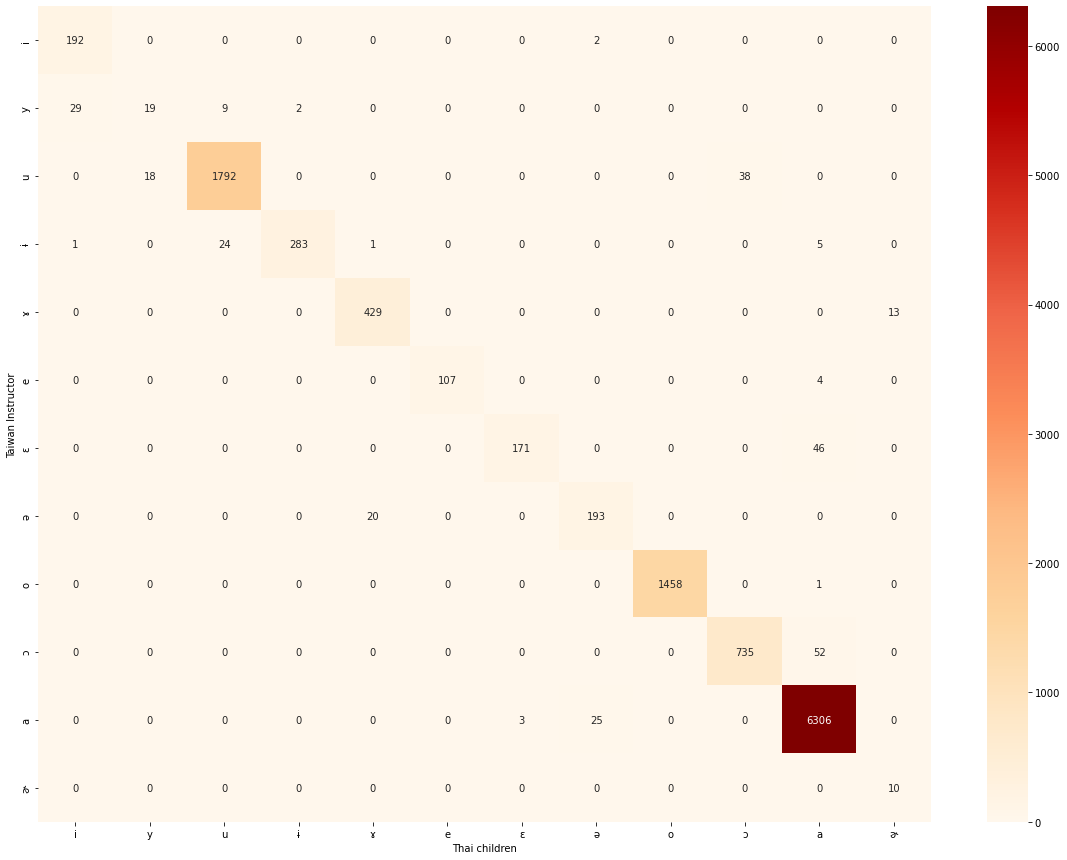

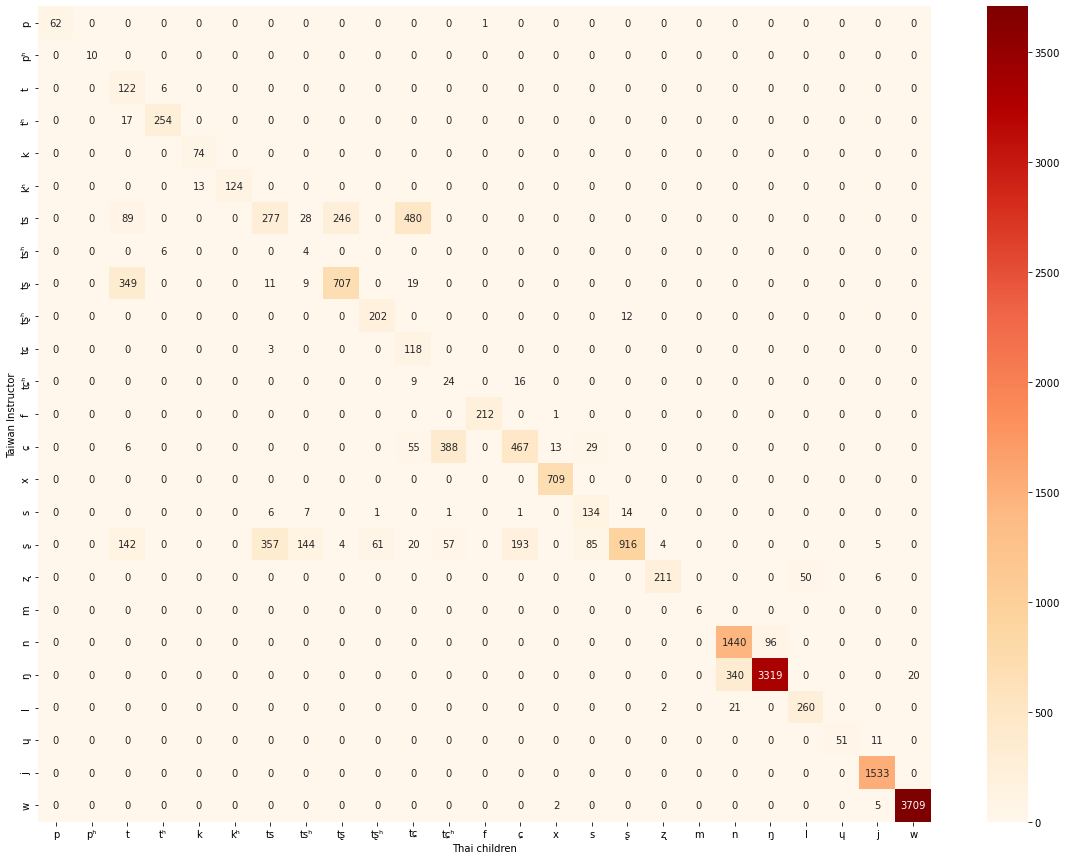

In [10]:
stat_main('data')